# **AiiDA-KKR tutorial - using workflows part I**

To harness the full stength of AiiDA we want be able to run complex workflows. In this tutorial we are learning to use some of the most important workflows that come with AiiDA-KKR.

In this section you will learn about
* the most important AiiDA-KKR workflows that use voronoi and KKRhost
* how to do a magnetic calculation with AiiDA-KKR
* how to perform a complete self-consistency and calculate the DOS and bandstructure from the converged result

This tutorial assumes that the basic concepts of AiiDA and AiiDA-KKR's calculations are known which are covered by the [basic calculations tutrorial of AiiDA-KKR](AiiDA-KKR_tutorial_basic_calculations.ipynb).

> **Note:**\
> In this tutorial the submission statements are commented out and instead the finished calculations are imported using the `load_node()` function.
> This requires importing the tutorial dataset using `verdi import aiida-kkr_tutorial_workflows_I.aiida` in ther terminal before executing this workflow.

In [1]:
#load aiida environment and connect to database
from aiida import load_profile
profile = load_profile()

## **1. `kkr_scf_wc` - full KKR self-consistency**

In this example we will import the structure of bcc Fe from a cif file and do our calculation with that imported structure. The cif input file for this example was downloaded from [materials project](https://materialsproject.org/materials/mp-13/).

The top level workflow we want to use is the `kkr_scf_wc` workflow of AiiDA-KKR that deal with doing a series of Voronoi and KKRhost calculations to converge a system. It has the following input and output nodes:

**Inputs:**
* `structure` - crystal structure for which the calculation is done (`StructureData`, *optional*)
* `remote_data` - parent calculation folder, used to continue a calculation instead of starting from a `StructureData` node (`RemoteData`, *optional*, required if structure is not in inputs)
* `wf_parameters` - settings for the workflow (Dict, *optional*)
* `options` - computer options (e.g. `'resources'={...}`, `'queue_name=...'`) that control how a calculation runs on the cluster (Dict, *optional*)
* `calc_parameters` - KKR parameters like the LMAX cutoff (`Dict`, *optional*)
* `voronoi` - Voronoi code installation (`Code`, *required* if structure is in inputs)
* `kkr` - KKR code installation (`Code`, *required*)

**Outputs:**
* 
* 

> **Note:**\
> The `wf_parameters` input node can easily be constructed from the `kkr_scf_wc.get_wf_defaults()` classmethod  that returns the default values for the settings.

We start by importing the structure from the downloaded cif file and visualize it.

In [2]:
# imports from aiida-core and aiida-kkr
from aiida.orm import CifData, Code, Dict, load_node
from aiida.engine import submit
from aiida_kkr.tools import kkrparams, plot_kkr
import os

cif = CifData(file=os.path.abspath('Fe_mp-13_symmetrized.cif'))
struc = cif.get_structure()

# the ase-notebook viewer also accepts additional keyword arguments like the unit cell repitition 'repeat_uc', 'zoom' or 'canvas_size':
p = plot_kkr(struc, repeat_uc=(2,2,2), zoom=2, canvas_size=(600,200), silent=True)

GridspecLayout(children=(Box(children=(Renderer(camera=PerspectiveCamera(far=1000.0, fov=10.0, near=1.0, posit…

In [3]:
# use pymatgen to find primitive structure
prim_struc = struc.get_pymatgen_structure().get_primitive_structure()
# convert to AiiDA StructureData
from aiida.orm import StructureData
struc_prim = StructureData(pymatgen=prim_struc)

plot_kkr(struc_prim, silent=True)

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 33.83687195684682), p…

For the test calculations we will activate magnetic initialization (using the `mag_init` key) and adapt some of the settings that optimize the runtime. The default values are chosen such that convergence is favored over speed. The workflow will then do `VoronoiCalculation`s and set the screening cluster radius (`RCLUSTZ`) such that a minimum of `natom_in_cls_min` atoms are included. Then a series of KKR calculations is done that first do simple mixing until `threshold_switch_high_accuracy` is met before a higher accuracy set (denser k-mesh, larger number of energy points) is used to reach final convergence (when the rms error of input and output potential surpasses `convergence_criterion`).

In [4]:
from aiida_kkr.workflows import kkr_scf_wc
settings, _ = kkr_scf_wc.get_wf_defaults()

# activate magnetic initialization, reduce convegence criterion and increase mixing
settings['mag_init'] = True
settings['natom_in_cls_min'] = 25
settings['convergence_criterion'] = 1e-6
settings['nsteps'] = 100
settings['threshold_switch_high_accuracy'] = 1e-2

Version of workflow: 0.10.4


We can then again use the process builder to set the inputs to the process and submit the calculations. Note that we only set the minimal set of parameters and most of the inputs parameters to the KKR calculation are actually found automatically. However they could still be set in `calc_parameters` or `wf_parameters`.

In [5]:
# create process builder
builder = kkr_scf_wc.get_builder()

# set structure input using the primitive structure
builder.structure = struc_prim

# set minimals et of KKR parameters
builder.calc_parameters = Dict(dict={'LMAX': 2, 'NSPIN': 2})

# set the workflow settings
builder.wf_parameters = Dict(dict=settings)

# set the codes and options
builder.voronoi = Code.get_from_string('voronoi_intel@iffslurm')
builder.kkr = Code.get_from_string('kkrhost_develop_intel@iffslurm')
# load options for the oscar partition of iffslurm (comes with iffslurm import file) which uses a single node for up to 1h with mpi
options_slurm_oscar = load_node('3b6c327e-d894-48ef-9f82-b45570149779')
builder.options = options_slurm_oscar

# set a calculation label and a description (optional)
builder.metadata.label = 'bccFe'
builder.metadata.description = 'bcc Fe imported from materials project (id=13)'

# finally submit the workflow and wait
#scf = submit(builder)
scf = load_node('c8f32ddd-39a6-4296-9a3f-b5881aa40fac')

We can check on the calculation's status using the `verdi process list` or the `verdi process status <id>` commands:

In [6]:
#!verdi process list -p1

In [7]:
#!verdi process status 312

The `plot_kkr` tool again gives us an overview plot of the workflow:

pk, uuid: 1262 c8f32ddd-39a6-4296-9a3f-b5881aa40fac
type: <class 'aiida.orm.nodes.process.workflow.workchain.WorkChainNode'>
label: bccFe
description: bcc Fe imported from materials project (id=13)
process type: aiida.workflows:kkr.scf
state: ProcessState.FINISHED

inputs:
[<StructureData: uuid: 75b299ee-07b1-4cf3-981c-545562239492 (pk: 1258)>,
 <Dict: uuid: 1cc8b3f8-e916-47d8-9971-fbf0da1ae376 (pk: 1259)>,
 <Dict: uuid: e7fd5c3a-14cd-4a60-9ef9-55c12cb241f3 (pk: 1260)>,
 <Code: Remote code 'voronoi_intel' on iffslurm, pk: 210, uuid: 13706052-384a-4504-bf68-073725945742>,
 <Code: Remote code 'kkrhost_develop_intel' on iffslurm, pk: 482, uuid: 14f74a01-9ebd-40fc-b5ef-f3086e168e60>,
 <Dict: uuid: a222a2ea-897d-49a1-9291-55e63832b490 (pk: 1261)>]

outputs:
[<CalcFunctionNode: uuid: 1711d57e-446d-4ccc-b06c-4c43ee1e1e3d (pk: 1265) (aiida_kkr.tools.common_workfunctions.update_params_wf)>,
 <WorkChainNode: uuid: b13b9958-43e5-41e3-9223-4ace15c54591 (pk: 1268) (aiida.workflows:kkr.startpot)>,
 

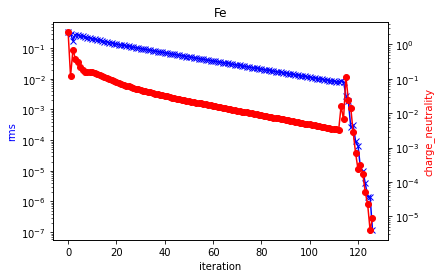

In [8]:
plot_kkr(scf)

We can easily reuse the settings of the previous scf calculation and run the calculation for the conventional cell as well. For this we use the `get_builder_restart` method and overwrite the `structure` input with the structure of the conventional cell:

In [9]:
# create process builder
builder = scf.get_builder_restart()
# overwrite structure input and set label
builder.structure = struc
builder.metadata.label = 'bccFe_conv'

# finally submit the workflow and wait
#scf_conv = submit(builder)
scf_conv = load_node('33320e88-90f6-4baa-84f5-992c69dc3006')

pk, uuid: 1482 33320e88-90f6-4baa-84f5-992c69dc3006
type: <class 'aiida.orm.nodes.process.workflow.workchain.WorkChainNode'>
label: bccFe_conv
description: 
process type: aiida.workflows:kkr.scf
state: ProcessState.FINISHED

inputs:
[<Dict: uuid: 1cc8b3f8-e916-47d8-9971-fbf0da1ae376 (pk: 1259)>,
 <Code: Remote code 'kkrhost_develop_intel' on iffslurm, pk: 482, uuid: 14f74a01-9ebd-40fc-b5ef-f3086e168e60>,
 <Dict: uuid: a222a2ea-897d-49a1-9291-55e63832b490 (pk: 1261)>,
 <StructureData: uuid: 97a0f8de-b68f-4d69-96b3-8ebc87603f0f (pk: 1481)>,
 <Code: Remote code 'voronoi_intel' on iffslurm, pk: 210, uuid: 13706052-384a-4504-bf68-073725945742>,
 <Dict: uuid: e7fd5c3a-14cd-4a60-9ef9-55c12cb241f3 (pk: 1260)>]

outputs:
[<CalcFunctionNode: uuid: 4162bba6-9303-4b88-82c7-3239baab0954 (pk: 1485) (aiida_kkr.tools.common_workfunctions.update_params_wf)>,
 <WorkChainNode: uuid: 15eb1aa4-ad45-4e67-b620-44d1e4a68102 (pk: 1488) (aiida.workflows:kkr.startpot)>,
 <CalcFunctionNode: uuid: 2741a60f-c156-4c

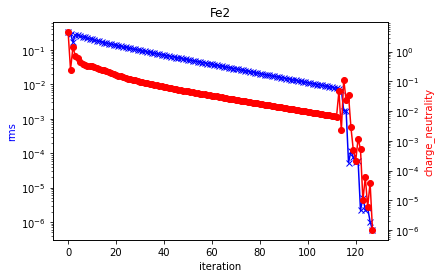

In [10]:
plot_kkr(scf_conv)

## **2. `kkr_dos_wc` and `kkr_bs_wc` - DOS and bandstructure calculations**

Here we continue from the converged calculations and compute the density of states and bandstructure and plot them side by side at the end of this section.

### **2.1 DOS calculation**

The DOS can easily be computed with the `kkr_dos_wc` workflow that has the following input and output nodes:

**Inputs:**
* `remote_data` - parent calculation folder (`RemoteData`, *required*)
* `wf_parameters` - settings for the workflow (Dict, *optional*)
* `options` - computer options (e.g. `'resources'={...}`, `'queue_name=...'`) that control how a calculation runs on the cluster (Dict, *optional*)
* `kkr` - KKR code installation (`Code`, *required*)

**Outputs:**
* 
* 

We compute the DOS in the energy range EF-10eV to EF+5eV and use a dense k-mesh for the calculation

In [11]:
from aiida_kkr.workflows import kkr_dos_wc
settings = kkr_dos_wc.get_wf_defaults()
settings

Version of workflow: 0.8.0


{'nepts': 96,
 'tempr': 200.0,
 'emin': -10.0,
 'emax': 5.0,
 'kmesh': [30, 30, 30],
 'RCLUSTZ': None}

In [12]:
builder = kkr_dos_wc.get_builder()
# reuse the KKRhost code and options from the scf calculation (primitive structure)
builder.kkr = scf.inputs.kkr
builder.options = scf.inputs.options
# set to converged output
builder.remote_data = scf.outputs.last_RemoteData
# set dos parameters
builder.wf_parameters = Dict(dict=settings)

#dos = submit(builder)
dos = load_node('48822ecd-4ba2-4b74-887d-2236b064a1cb')

### **2.2 band structure calculation**

The bandstructure can easily be computed with the `kkr_bs_wc` workflow that has the following input and output nodes:

**Inputs:**
* `remote_data` - parent calculation folder (`RemoteData`, *required*)
* `wf_parameters` - settings for the workflow (Dict, *optional*)
* `options` - computer options (e.g. `'resources'={...}`, `'queue_name=...'`) that control how a calculation runs on the cluster (Dict, *optional*)
* `kkr` - KKR code installation (`Code`, *required*)

**Outputs:**
* 
* 

For the bandstructure calculation we want to increase the screening cluster radius `RCLUSTZ` which can be set in the workflow parameters:

In [13]:
from aiida_kkr.workflows import kkr_bs_wc
settings = kkr_bs_wc.get_wf_defaults()
print("'RCLUSTZ' from converged calc: {} a_lat".format(scf.outputs.last_InputParameters['RCLUSTZ']))
settings['RCLUSTZ'] = 2.3 # increase 
settings

Version of the kkr_bs_wc workflow: 0.1.1
'RCLUSTZ' from converged calc: 1.6331509900882 a_lat


{'emin': -10.0, 'emax': 5.0, 'nepts': 96, 'RCLUSTZ': 2.3, 'tempr': 50.0}

We can now submit the bandstructure workflow for both primitive and conventional structures:

In [14]:
def get_builder_bs(scf_node, settings):
    """
    helper function to set up the process builder
    """
    builder = kkr_bs_wc.get_builder()
    # reuse the KKRhost code and options from the scf calculation
    builder.kkr = scf_node.inputs.kkr
    builder.options = scf_node.inputs.options
    # set to converged output
    builder.remote_data = scf_node.outputs.last_RemoteData
    # set dos parameters
    builder.wf_parameters = Dict(dict=settings)
    
    return builder

# first we submit the calculation for the primitive structure
builder = get_builder_bs(scf, settings)
#bandstruc = submit(builder)
bandstruc = load_node('50dc542b-588a-41dd-b33b-f6978a092ae8')

In [15]:
# then we submit the calculation for the conventional structure
builder = get_builder_bs(scf_conv, settings)
#bandstruc_conv = submit(builder)
bandstruc_conv = load_node('19a802d4-13fb-4d2a-ac63-642d396e8612')

We can again use the `plot_kkr` tool to create a plot of the output. In this example we use the `noshow` and `nofig` keywords to prevent `plot_kkr` from opening a new figure and showing the generated plot immediately. This allows us to combine plots: 

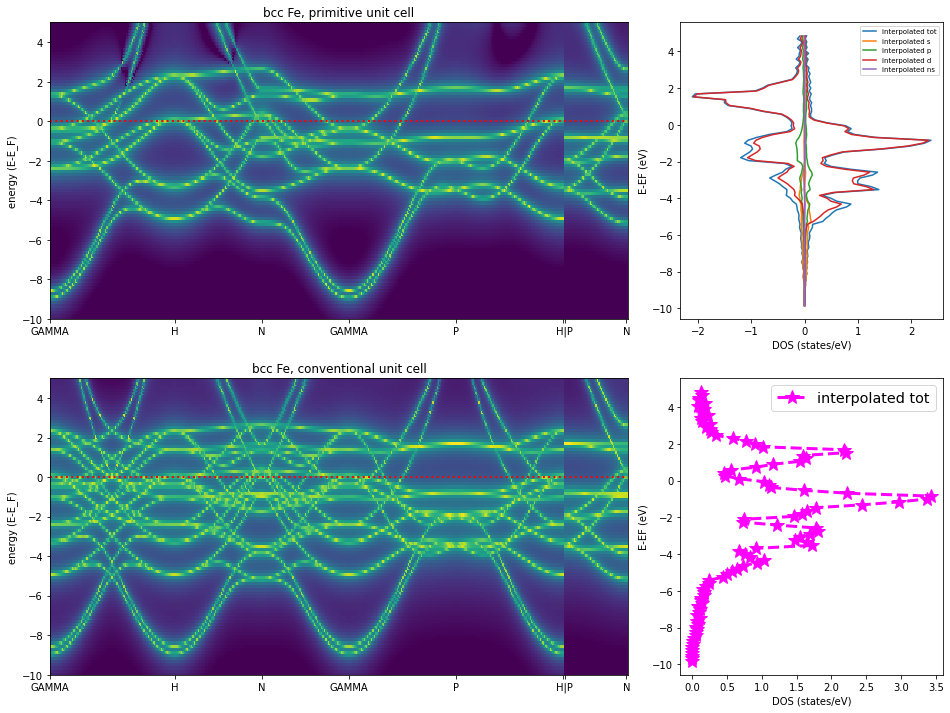

In [26]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# create a figure and a gridspec layout to control the sizes of the bandstructure and DOS plots
fig = plt.figure(figsize=(16,12))
gs = gridspec.GridSpec(2,3)

# first plot: bandstructure
ax1 = fig.add_subplot(gs[0,:2])
plot_kkr(bandstruc, silent=True, noshow=True, nofig=True, show_cbar=False)
# we can remove the plot title:
plt.title('bcc Fe, primitive unit cell')

# second plot: DOS, switch x and y to match the band structure plot
ax2 = fig.add_subplot(gs[0,2])
plot_kkr(dos, silent=True, switch_xy=True, nofig=True, noshow=True)
plt.title('')

ax3 = fig.add_subplot(gs[1,:2])
plot_kkr(bandstruc_conv, silent=True, noshow=True, nofig=True, show_cbar=False)
plt.title('bcc Fe, conventional unit cell')

ax4 = fig.add_subplot(gs[1,2])
plot_kkr(dos, switch_xy=True, nofig=True, noshow=True,
         # we can also control the plot's appearance with common keyword arguments
         color='magenta', sum_spins=True, l_channels=False, lw=3, ls='--', marker='*', markersize=15,
         silent=True, ptitle='modified appearance')
# and we can overwrite some behavior with standard matplotlib commands
plt.legend(fontsize='x-large')
plt.title('')

# we can also save this figure (here in png and pdf versions)
plt.savefig('bandstruc_dos.png')
plt.savefig('bandstruc_dos.pdf')

plt.show()